# 0. Introduction

Random Forests comprise a family of simple yet robust algorithms. Their ease of use makes them popular among Machine Learning competition platforms, such as Kaggle and DrivenData. In this tutorial, we will set-up a simple Random Forest classifier and train it on real-world data. 

In the aftermath of the 2015 7.8 $M_w$ Gorkha earthquake, the National Planning Commission of Nepal conducted an extensive survey of the damage sustained by affected households. From the [2015 Nepal Earthquake Open Data portal](https://eq2015.npc.gov.np/):

> _Following the 7.8 Mw Gorkha Earthquake on April 25, 2015, Nepal carried out a massive household survey using mobile technology to assess building damage in the earthquake-affected districts. Although the primary goal of this survey was to identify beneficiaries eligible for government assistance for housing reconstruction, it also collected other useful socio-economic information. In addition to housing reconstruction, this data serves a wide range of uses and users e.g. researchers, newly formed local governments, and citizens at large. The purpose of this portal is to open this data to the public._

In the [DrivenData _Richter's Predictor_ competition](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/), the goal is to predict the level of damage based on geographic, structural, and socio-economical descriptors (building location, height, construction materials, number of resident families, etc.). A task ideally suited to tackle with a Random Forest classifier.

# 1. Preparing the data

First we need to read and prepare (a part of) the data. As this is not an intrinsic part of the Machine Learning workflow, I will skip the explanation.

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Defining paths to data files
data_dir = "data"
file_values = os.path.join(data_dir, "train_values.csv")
file_labels = os.path.join(data_dir, "train_labels.csv")

# A map to convert non-numeric values
value_map = {
    "land_surface_condition": ["n", "o", "t"],
    "foundation_type": ["h", "i", "r", "u", "w"],
    "roof_type": ["n", "q", "x"],
    "ground_floor_type": ["f", "m", "v", "x", "z"],
    "other_floor_type": ["j", "q", "s", "x"],
    "position": ["j", "o", "s", "t"],
    "plan_configuration": ["a", "c", "d", "f", "m", "n", "o", "q", "s", "u"],
    "legal_ownership_status": ["a", "r", "v", "w"],
}

# Read data files (limit lines read to N)
print("Reading data")
N = int(5e4)
values = pd.read_csv(file_values, header=0, delimiter=",", nrows=N)
labels = pd.read_csv(file_labels, header=0, delimiter=",", nrows=N)

# Drop building ID (not used)
values.drop("building_id", axis=1, inplace=True)
labels.drop("building_id", axis=1, inplace=True)

# Convert non-numeric values
print("Remapping values")
for key, val in value_map.items():
    replacements = np.arange(len(val))
    val_dict = dict(zip(val, replacements))
    values[key].replace(to_replace=val_dict, inplace=True)

print("Done")

Reading data
Remapping values
Done


# 2. Training a Random Forest classifier

Next, we import the desired modules from [scikit-learn](https://scikit-learn.org/stable/). In this tutorial we will use a Random Forest classifier (appropriately named `RandomForestClassifier`; from now on abbreviated to RF), but there are many more algorithms and tools in the box of scikit-learn (support vector machines, clustering algorithms, PCA).

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Now that the data have been loaded into memory, we split the features and labels into a training set and a test set. Usually around 80% of the data is used for training of the RF classifier, and the remaining 20% is used for testing the performance (and to make sure the model is not just overfitting).

In [3]:
train_values, test_values, train_labels, test_labels = train_test_split(values, labels, test_size=0.2, random_state=0)
# Changing the dimensions from (N, 1) to just (N). Otherwise sklearn will throw a warning
train_labels = np.ravel(train_labels)

The RF classifier first needs to be initialised, which is done as follows:

In [4]:
forest = RandomForestClassifier(n_estimators=200, random_state=0)

With the above line, we initialise a forest with 200 decision trees. The random state is fixed for reproducibility in this tutorial (so that we all get exactly the same results), but this is not required in general. Aside from these specified parameters, there are 12 other parameters by which you can tweak the performance of the RF.

We are now ready to train the classifier, which in scikit terms is called "fitting":

In [5]:
print("Training forest (\"Eye of the Tiger\")")
forest.fit(train_values, train_labels)
print("Done training")

Training forest ("Eye of the Tiger")
Done training


When the training is done, we use the trained classifier to make predictions on the data is has not seen yet (the test set). In the competition the "F1 score" is used as a performance metric, which is nicely explained on the [competition's webpage](https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/):

>_We are predicting the level of damage from 1 to 3. The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem. (Ordinal regression is sometimes described as an problem somewhere in between classification and regression.)_
>
>_To measure the performance of our algorithms, we'll use the F1 score which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the micro averaged F1 score._
$$
F_{micro} = \frac{2 \cdot P_{micro} \cdot R_{micro}}{P_{micro} + R_{micro}}
$$
_where_
$$
P_{micro} = \frac{\sum_{k=1}^3 TP_k}{\sum_{k=1}^3 \left(TP_k + FP_k \right)}, \quad R_{micro} = \frac{\sum_{k=1}^3 TP_k}{\sum_{k=1}^3 \left(TP_k + FN_k \right)}
$$

In [6]:
train_predictions = forest.predict(train_values)
train_score = f1_score(train_labels, train_predictions, average="micro")

test_predictions = forest.predict(test_values)
test_score = f1_score(test_labels, test_predictions, average="micro")
print("Training F1 score: %.3f \t Test F1 score: %.3f" % (train_score, test_score))

Training F1 score: 0.997 	 Test F1 score: 0.704


It is clear from the vast difference in training/test performance that the model is overfitting. Nonetheless, an F1 score of `0.7` is not far off from the current leader in the competition (with an F1 score of `0.7536`). The performance on the test set likely increases when more data is included and more decision trees are added, at the expense of computation time.

# 3. Interpretation

For scientific purposes, interpretation is often more important than predictive performance. Random Forests can be interrogated relatively easily to assess the relative importance of each component of the input (i.e. which features contribute most to the final prediction).

In [7]:
# Get the relative importances
importances = forest.feature_importances_
# Estimate the uncertainty in the relative importance of each feature
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
print(importances)

[1.40455903e-01 1.37361797e-01 1.49554714e-01 1.95405158e-02
 1.07070909e-01 1.00877405e-01 6.07825392e-02 2.04868629e-02
 2.56190069e-02 2.63726936e-02 1.87199953e-02 2.07661523e-02
 2.20487665e-02 9.34288522e-03 9.17687496e-03 1.63614632e-02
 6.13740481e-03 3.47009060e-03 6.65706540e-03 9.94707106e-03
 1.30391518e-02 7.70360651e-03 5.40354403e-03 3.34900993e-03
 3.54116307e-03 8.42872668e-03 2.42678076e-02 9.20793637e-03
 6.57174417e-03 4.28368691e-03 1.31069781e-03 1.97421021e-04
 1.76838983e-04 4.08390779e-04 9.83573873e-05 3.03742356e-05
 8.44691059e-05 1.14695787e-03]


We now have an array of relative importances, in which the first element refers to the first feature, etc. To visualise the features, we order the features in descending importance and plot the results.

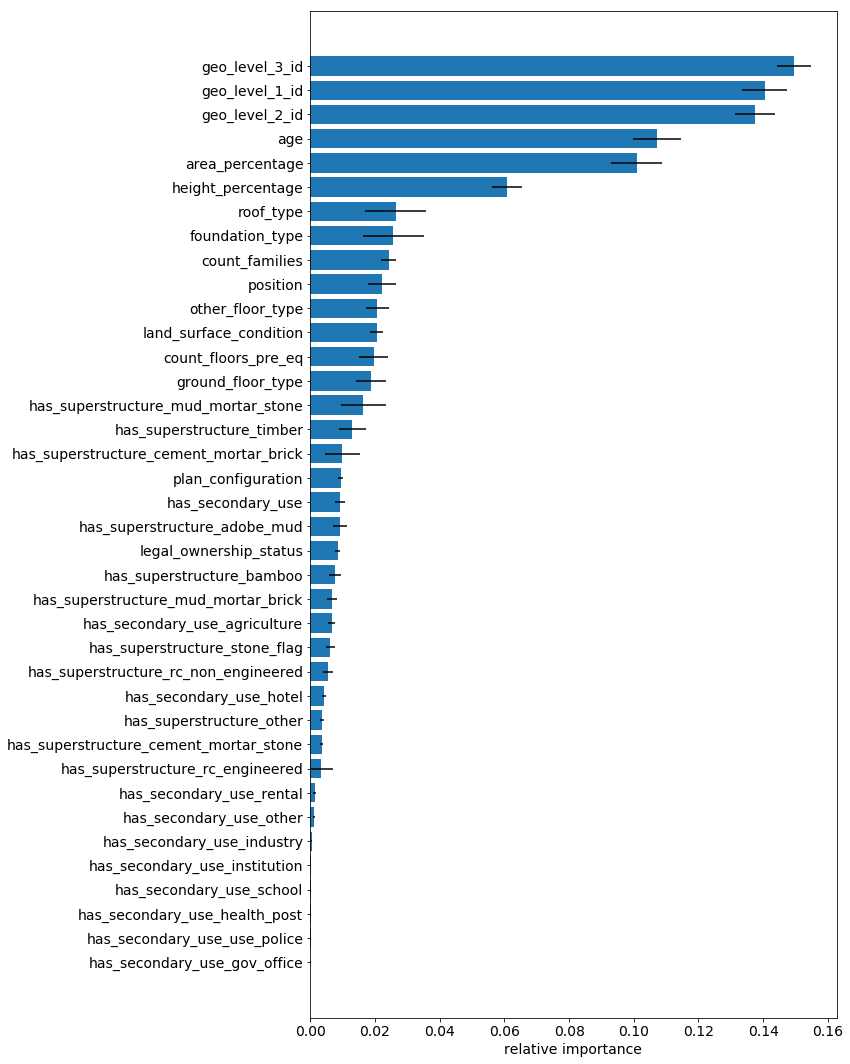

In [8]:
# Convert dataframe column names to a list of feature names
features = np.array(values.columns.tolist())
# Assign a number to each feature
num_features = np.arange(len(features))
# Sorting indices
inds = np.argsort(importances)

# Plot results
plt.rcParams.update({"font.size": 14})
plt.figure(figsize=(12, 15))
plt.barh(num_features, importances[inds], xerr=std[inds])
plt.yticks(ticks=num_features, labels=features[inds], rotation="horizontal", fontsize=14)
plt.xlabel("relative importance")
plt.xlim(left=0)
plt.tight_layout()

__Warning__: correlation does not imply causation! The relative importance of each feature extracted from the RF only indicates the strength of the correlation between that feature and the final predicted level of damage.

Location and age of the building correlate strongly with the level of damage, as can intuitively be expected. Second-order features such as the type of roof and the number of families living in a building are not so easily interpreted (perhaps more people means more weight on each floor?). The secondary use of a building seems completely irrelevant for the damage predictions.